# 0.0 IMPORTS

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!pip install virtualenv

In [3]:
#installing virtualenv nesse diretório
#porém se o virtualenv já existir ainda assim precisa dar esse comando para depois usar o activate
#!virtualenv /content/drive/MyDrive/ds_em_producaoenv
#!source /content/drive/MyDrive/ds_em_producaoenv/bin/activate

In [4]:
#quando quiser instalar uma biblioteca no env permanente.
#Por algum motivo tem que passar por todas as bibliotecas para verificar
#import sys
#sys.path.append("/content/drive/MyDrive/ds_em_producaoenv/lib/python3.10/site-packages")
#!source /content/drive/MyDrive/ds_em_producaoenv/bin/activate; pip install inflection
#!source /content/drive/MyDrive/ds_em_producaoenv/bin/activate; pip install tabulate
#!source /content/drive/MyDrive/ds_em_producaoenv/bin/activate; pip install sklearn
#!source /content/drive/MyDrive/ds_em_producaoenv/bin/activate; pip install boruta

In [5]:
#!source /content/drive/MyDrive/ds_em_producaoenv/bin/activate; pip list

In [6]:
#Gerar arquivo requirements
#%cd '/content/drive/MyDrive/Colab Notebooks/ds_em_producao'
#!pip freeze > requirements.txt

In [7]:
#!pip install -r '/content/drive/MyDrive/Colab Notebooks/ds_em_producao/requirements.txt'

# 0.1 IMPORTS

In [270]:
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
import random
import warnings


from IPython.display import Image
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from scipy import stats
from sklearn.preprocessing import RobustScaler, LabelEncoder, MinMaxScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_percentage_error
from sklearn.linear_model import LinearRegression, Lasso
from boruta import BorutaPy

ImportError: cannot import name 'mean_percentage_error' from 'sklearn.metrics' (C:\Users\edils\anaconda3\envs\Data-Science-Em-Producao\lib\site-packages\sklearn\metrics\__init__.py)

## 0.2 Helper Functions

In [271]:

def cramer_v( x, y ):
  cm = pd.crosstab( x, y ).to_numpy()
  n = cm.sum()
  r, k = cm.shape

  chi2 = stats.chi2_contingency( cm )[0]
  chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)
  return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '<style>.container { width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()
    
def mean_percentage_error(y, yhat):
    return np.mean((y-yhat)/y)

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_validation(xtraining, k_fold, model_name, model, verbose=False):

    k_fold = k_fold
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed (range(1,k_fold+1)):
        if verbose:
            print(f"\nK-Fold Number: {k}")

        #start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        #filtering dataset
        training = x_training.loc[x_training['date'] < validation_start_date]
        validation = x_training.loc[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset
        xtraining = training.drop(['sales','date'], axis=1)
        ytraining = training['sales']
        xvalidation = validation.drop(['sales','date'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model

        #training
        m.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': f"{round(np.mean(mae_list),2)} +/- {round(np.std(mae_list),2)}",
                         'MAPE CV': f"{round(np.mean(mape_list),2)} +/- {round(np.std(mape_list),2)}",
                         'RMSE CV': f"{round(np.mean(rmse_list),2)} +/- {round(np.std(rmse_list),2)}"},index=[0])

In [10]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.3 Loading Data

In [11]:
path = 'C:\\Users\\edils\\repos\\ds_em_producao\\Data-Science-Em-Producao\\data\\'

In [12]:
df_sales_raw = pd.read_csv(path + 'train.csv', low_memory=False)
df_store_raw = pd.read_csv(path + 'store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DATA DESCRIPTION

In [13]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [14]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [15]:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,df1.columns))
df1.columns = cols_new

## 1.2. Data Dimensions

In [16]:
df1.shape

(1017209, 18)

## 1.3. Data Types

In [17]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [18]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4. Check NA

In [19]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.4.2 Fillout NA

In [20]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [21]:
# competition_distance 
##coloca um valor extremamente alta se o competition distance for NaN
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if np.isnan(x) else x)

# competition_open_since_month
##Se o valor for NaN substitui o mês localizado na coluna date
filtro_mes = lambda x: x['date'].month if np.isnan(x['competition_open_since_month']) else x['competition_open_since_month']
df1['competition_open_since_month'] = df1.apply(filtro_mes, axis=1) 
    
 # competition_open_since_year 
filtro_ano = lambda x: x['date'].year if np.isnan(x['competition_open_since_year']) else x['competition_open_since_year']
df1['competition_open_since_year'] = df1.apply(filtro_ano, axis=1)              
               
# promo2_since_week
filtro_promo_week = lambda x: x['date'].week if np.isnan(x['promo2_since_week']) else x['promo2_since_week']
df1['promo2_since_week'] = df1.apply(filtro_promo_week, axis=1)    

# promo2_since_year
filtro_promo_year = lambda x: x['date'].year if np.isnan(x['promo2_since_year']) else x['promo2_since_year']
df1['promo2_since_year'] = df1.apply(filtro_promo_year, axis=1)

# promo_interval 
df1['promo_interval'].fillna(0,inplace=True)

months = { 1: 'Jan',
           2: 'Feb',
           3: 'Mar',
           4: 'Apr',
           5: 'May',
           6: 'Jun',
           7: 'Jul',
           8: 'Aug',
           9: 'Sept',
           10: 'Oct',
           11: 'Nov',
           12: 'Dec',
         }
##cria um coluna month_map com o nome do mês baseado na coluna date
df1['month_map'] = df1['date'].apply(lambda x: x.month)
def numero_em_mes(mes):
  return months[mes]
df1['month_map'] = df1['month_map'].apply(numero_em_mes) 
##cria uma coluna is_promo: se o mês do month_map estiver dentro da coluna promo_interval, retorna 1, senão 0
filtro_promo_map = lambda x: 1 if x['month_map'] in x['promo_interval'].split(',') else 0
df1['is_promo'] = df1.apply(lambda x: (1 if x['month_map'] in x['promo_interval'].split(',') else 0) if x['promo_interval'] != 0 else 0, axis=1)

In [22]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5. Change Types

In [23]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [24]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.6. Descriptive Statistical

In [25]:
num_attributes = df1.select_dtypes(include=['int','float'])
categorical_attributes = df1.select_dtypes(exclude=['int','float'])

### 1.6.1 Numerical Attributes

In [26]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = num_attributes.agg(['std','mean','min','max', lambda x: x.max()-x.min(),'skew','kurtosis']).T.reset_index()
d1.rename(columns={'index':'attributes','<lambda>':'range'})


,attributes,std,mean,min,max,range,skew,kurtosis
0,store,321.908651,558.429727,1.0,1115.0,1114.0,-0.000955,-1.200524
1,day_of_week,1.997391,3.998341,1.0,7.0,6.0,0.001593,-1.246873
2,sales,3849.926175,5773.818972,0.0,41551.0,41551.0,0.641460,1.778375
3,customers,464.411734,633.145946,0.0,7388.0,7388.0,1.598650,7.091773
4,open,0.375539,0.830107,0.0,1.0,1.0,-1.758045,1.090723
5,promo,0.485759,0.381515,0.0,1.0,1.0,0.487838,-1.762018
6,school_holiday,0.383056,0.178647,0.0,1.0,1.0,1.677842,0.815154
7,competition_distance,12547.652996,5935.442677,20.0,200000.0,199980.0,10.242344,147.789712
8,competition_open_since_month,3.311087,6.786849,1.0,12.0,11.0,-0.042076,-1.232607
9,competition_open_since_year,5.515593,2010.324840,1900.0,2015.0,115.0,-7.235657,124.071304


### 1.6.2 Categorical Attributes

In [27]:
categorical_attributes.apply(lambda x: x.nunique())

date              942
state_holiday       4
store_type          4
assortment          3
promo_interval      4
month_map          12
dtype: int64

C:\Users\edils\AppData\Local\Temp\ipykernel_19056\1932886497.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
C:\Users\edils\AppData\Local\Temp\ipykernel_19056\1932886497.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


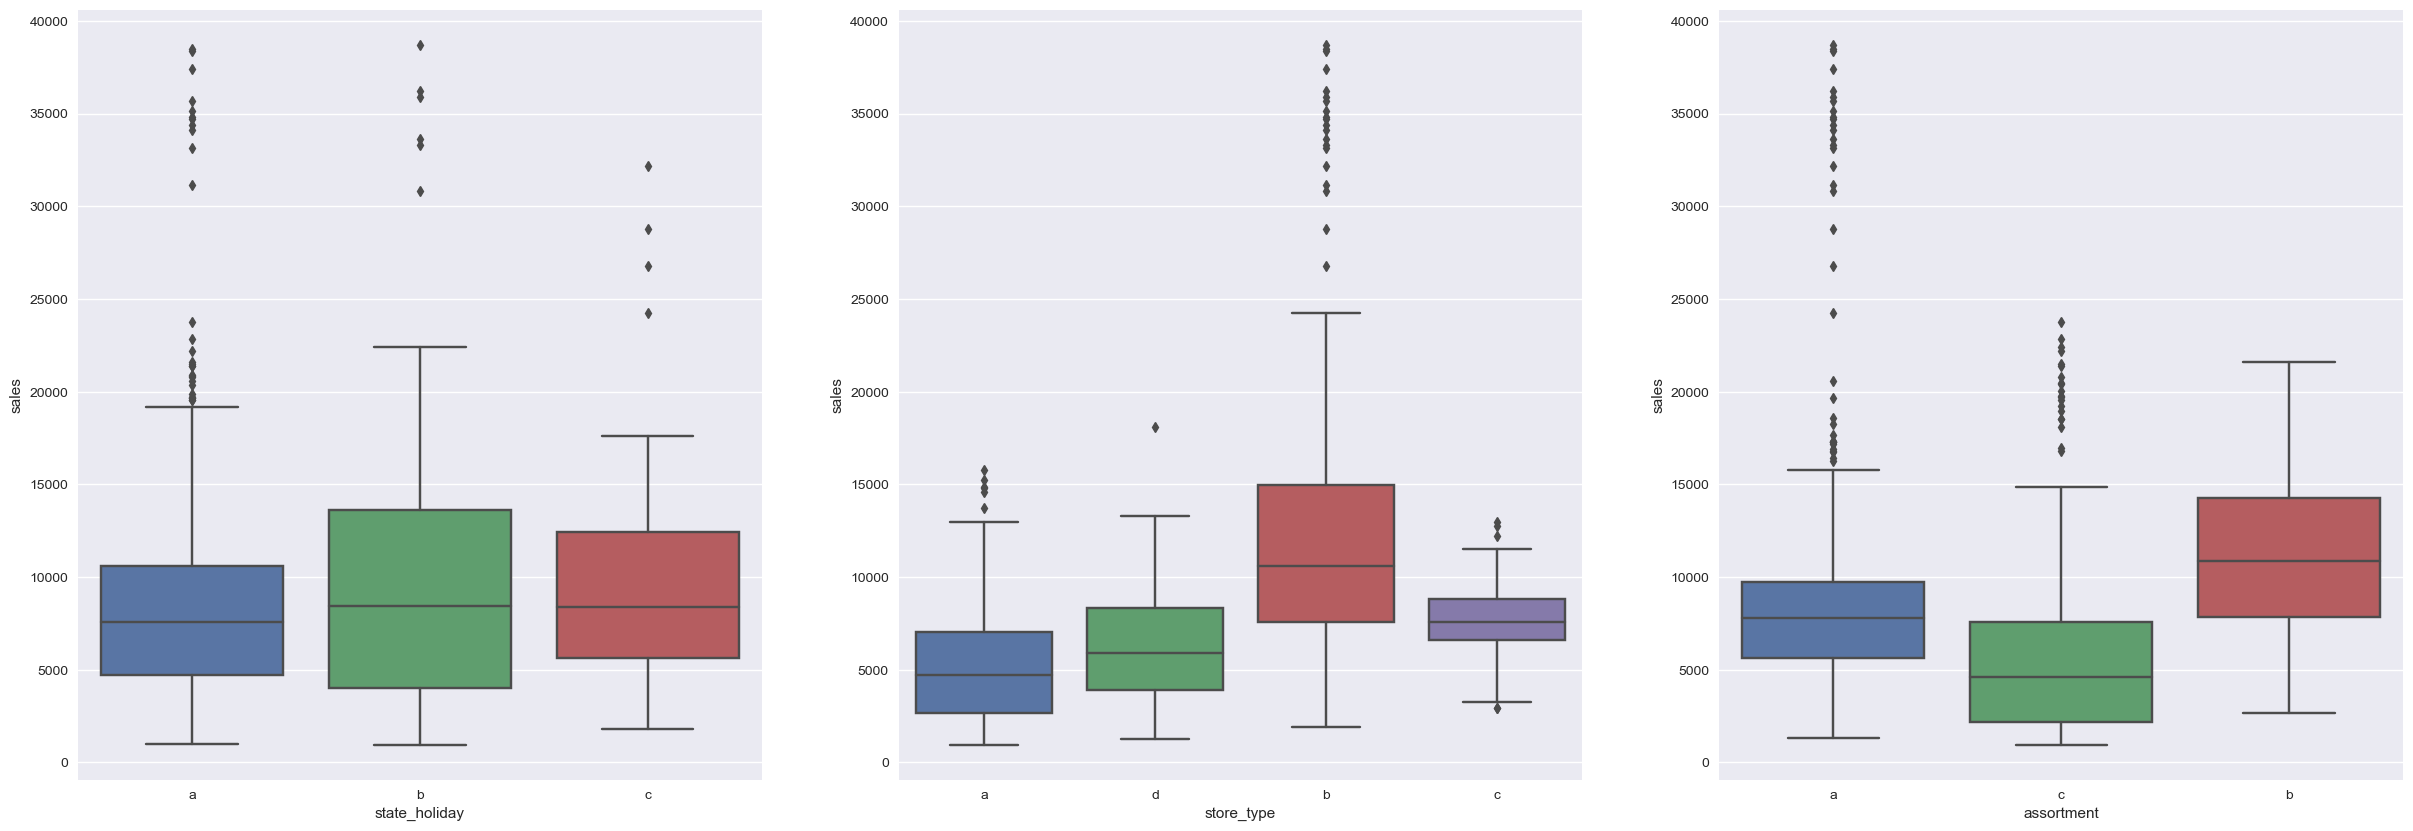

In [28]:
df1_aux = df1.loc[(df1['sales'] > 0) & (df1['state_holiday'] != '0'),:]

plt.style.use('seaborn')
fig = plt.figure(figsize=(30, 10))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=df1_aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=df1_aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=df1_aux)

plt.subplots_adjust(wspace=0.2)

fig.show()


# 2.0 FEATURE ENGINEERING

In [29]:
df2 = df1.copy()

## 2.1. Lista de Hipóteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores a mais tempo deveriam vender mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana
12. Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Feature Engineering

In [30]:
df2.sample(10).T

,833504,948555,212511,559015,662654,930788,820020,223494,194183,628818
store,270,476,662,71,15,549,166,495,174,744
day_of_week,5,7,4,6,4,2,3,1,6,7
date,2013-06-14 00:00:00,2013-03-03 00:00:00,2015-01-22 00:00:00,2014-02-15 00:00:00,2013-11-14 00:00:00,2013-03-19 00:00:00,2013-06-26 00:00:00,2015-01-12 00:00:00,2015-02-07 00:00:00,2013-12-15 00:00:00
sales,8564,0,5753,7149,5569,4659,4035,7036,6297,0
customers,1144,0,615,605,595,521,648,496,525,0
open,1,0,1,1,1,1,1,1,1,0
promo,0,0,0,0,0,1,0,1,0,0
state_holiday,0,0,0,0,0,0,0,0,0,0
school_holiday,0,0,0,0,0,0,0,0,0,0
store_type,a,d,d,a,d,a,a,d,a,a


In [31]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
##Junta as duas colunas em uma só
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)

#promo since
#Junta as duas colunas em uma só transformando a semana em mês
df2['promo_since'] = df2.apply(lambda x: datetime.datetime.strptime(f"{x['promo2_since_year']}-{x['promo2_since_week']-1}-1", '%Y-%W-%w'),axis=1)

#assortment
assortments = {'a' : 'basic', 'b' : 'extra', 'c' : 'extended'}
def name_assortsments(valor):
  return assortments[valor]

df2['assortment'] = df2['assortment'].apply(name_assortsments)

#state holiday 
holidays = {'a' : 'public_holiday', 'b' : 'easter_holiday', 'c' : 'christmas', '0' : 'regular_day'}
def name_holidays(valor):
  return holidays[valor]

df2['state_holiday'] = df2['state_holiday'].apply(name_holidays)

#promo_time_week signifca quantos dias apos o pedido a promo2 está ativa(estendida)
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

C:\Users\edils\AppData\Local\Temp\ipykernel_19056\592591277.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 VARIABLE FILTERING

In [32]:
df3 = df2.copy()

In [33]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week,competition_time_month
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,2015-07-27,0,84
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,2010-03-22,279,94
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,2011-03-28,226,105
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,2015-07-27,0,71
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,2015-07-27,0,4


## 3.1.Line Filtering

In [34]:
#retirar coluna 'open' porque quando a loja está fechada não tem vendas
#filtrar coluna sales > 0 porque não quero sales negativa
df3 = df3.loc[(df3['sales']>0) & (df3['open'] != 0 ) ]

## 3.2. Columns Selection

In [35]:
#dropar coluna costumers porque não vou ter quantos customer estarão na loja daqui a 6 semanas
#dropar open porque só vai sobrar '1' na coluna
#os outros drops são colunas derivadas
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 EXPLORATORY DATA ANALISYS

In [36]:
df4 = df3.copy()

In [37]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week,competition_time_month
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,2015-07-27,0,84
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,2010-03-22,279,94
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,2011-03-28,226,105
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,2015-07-27,0,71
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,2015-07-27,0,4


In [38]:
df4.sample(10).T

,765021,243611,459644,55509,649795,316262,270090,478857,876726,638546
store,917,826,1050,875,536,483,61,193,7,437
day_of_week,4,3,5,5,2,2,2,1,1,5
date,2013-08-15 00:00:00,2014-12-24 00:00:00,2014-05-16 00:00:00,2015-06-12 00:00:00,2013-11-26 00:00:00,2014-10-07 00:00:00,2014-11-25 00:00:00,2014-04-28 00:00:00,2013-05-06 00:00:00,2013-12-06 00:00:00
sales,6612,7500,5541,4161,7496,7158,5935,7850,8820,6243
promo,1,0,0,0,0,1,1,1,0,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,0,0,0,0,0,0,0,0
store_type,a,a,d,d,a,a,a,a,a,c
assortment,basic,extended,extended,basic,extended,extended,extended,basic,extended,extended
competition_distance,7240.0,7980.0,13170.0,5070.0,4700.0,2310.0,350.0,520.0,24000.0,430.0


## 4.1 Unilateral Analysis

### 4.1.1 Response Variable

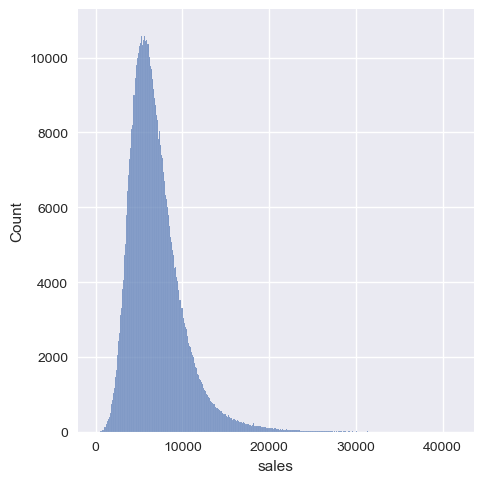

In [39]:
sns.displot(df4['sales']);

### 4.1.2 Numerical Variables

C:\Users\edils\AppData\Local\Temp\ipykernel_19056\953079709.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  num_attributes.hist(ax = ax, bins=25);


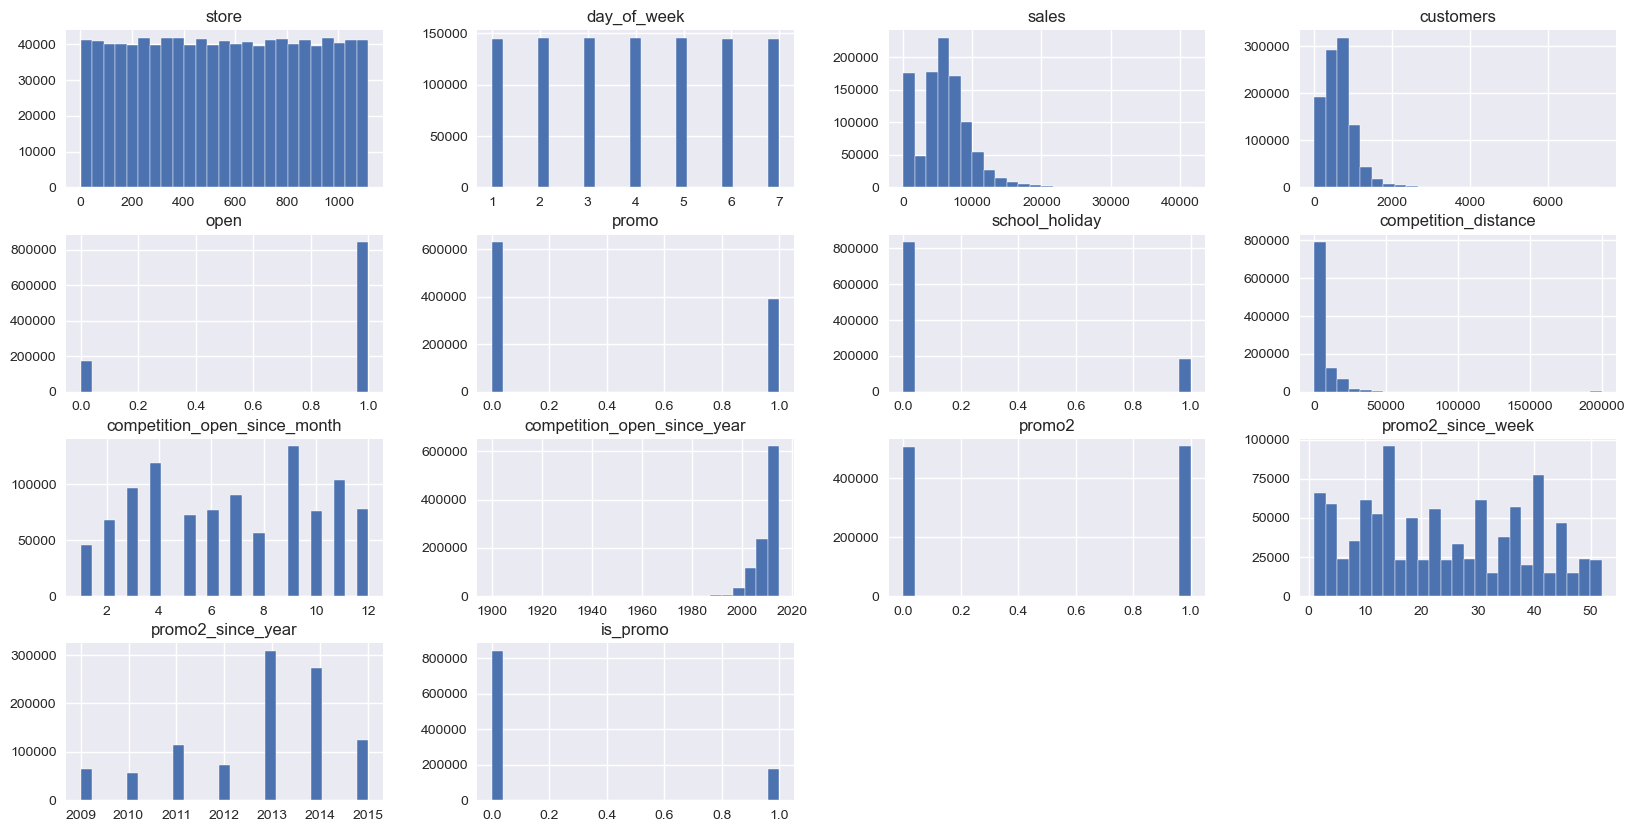

In [40]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
num_attributes.hist(ax = ax, bins=25);

### 4.1.3 Categorical Variable

<Axes: xlabel='sales', ylabel='Density'>

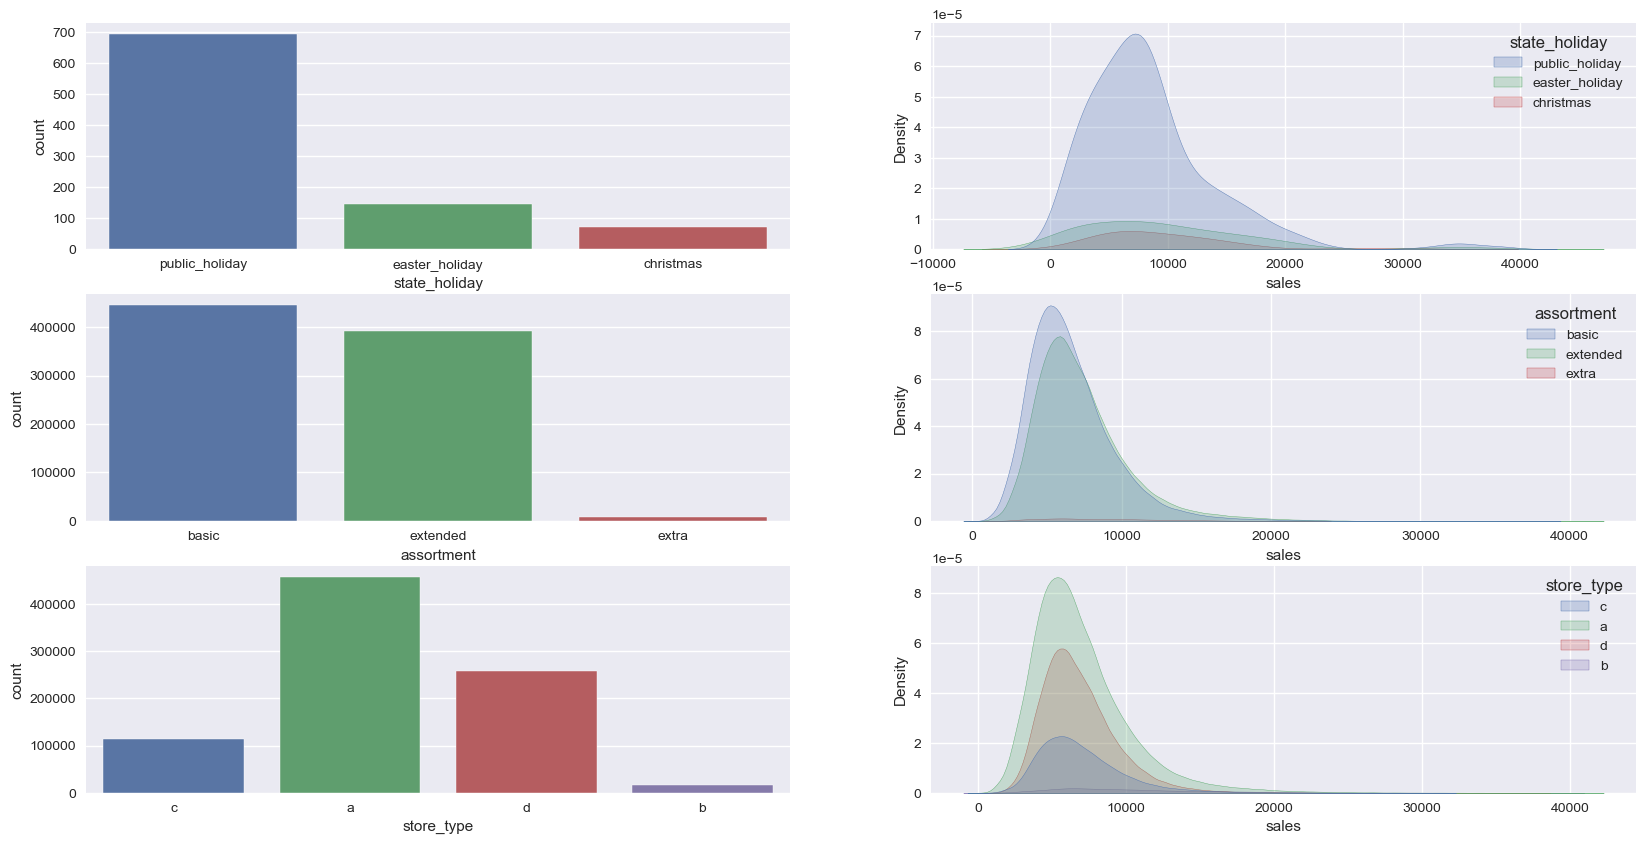

In [41]:
not_regular_day = df4.loc[df4['state_holiday'] != 'regular_day',['sales','state_holiday']]

#state_holiday
fig = plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
sns.countplot(data = not_regular_day, x='state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(data=not_regular_day, x='sales', hue='state_holiday', fill=True)

#assortment
plt.subplot(3,2,3)
sns.countplot(data = df4, x='assortment')

plt.subplot(3,2,4)
sns.kdeplot(data=df4, x='sales', hue='assortment', fill=True)

#store_type
plt.subplot(3,2,5)
sns.countplot(data = df4, x='store_type')

plt.subplot(3,2,6)
sns.kdeplot(data=df4, x='sales', hue='store_type', fill=True)


## 4.2 Bilateral Analysis

### 4.2.1 - H1 - Lojas com maior sortimentos deveriam vender mais.
**Supondo que o sortimento extra seja o maior, a hipótese é falsa,
porque a extra possui a menor quantidade de venda dos 3 sortimentos**

<Axes: xlabel='year_week'>

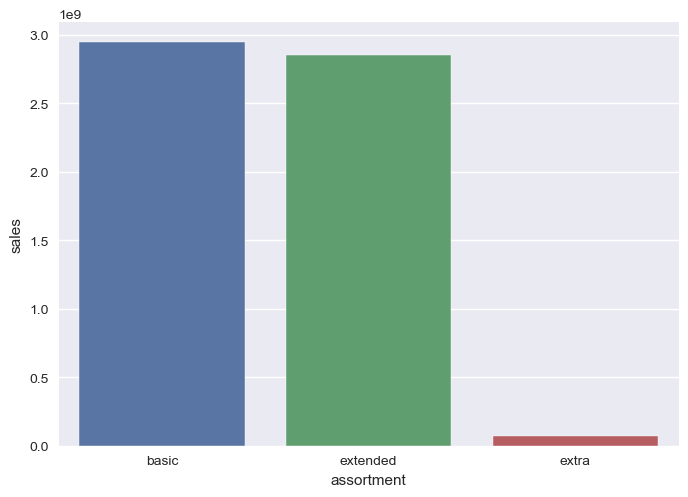

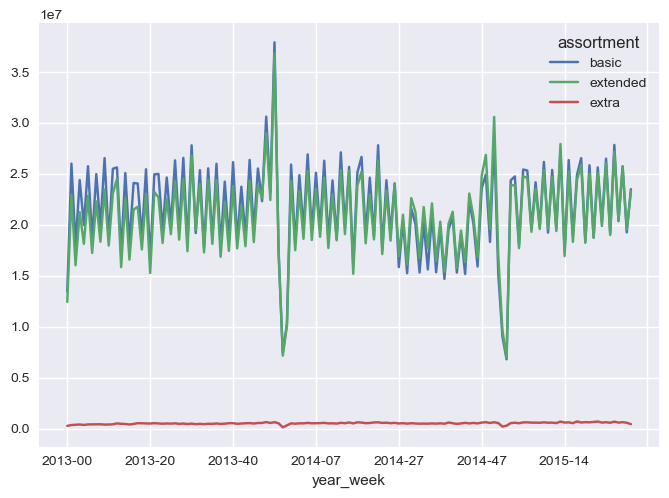

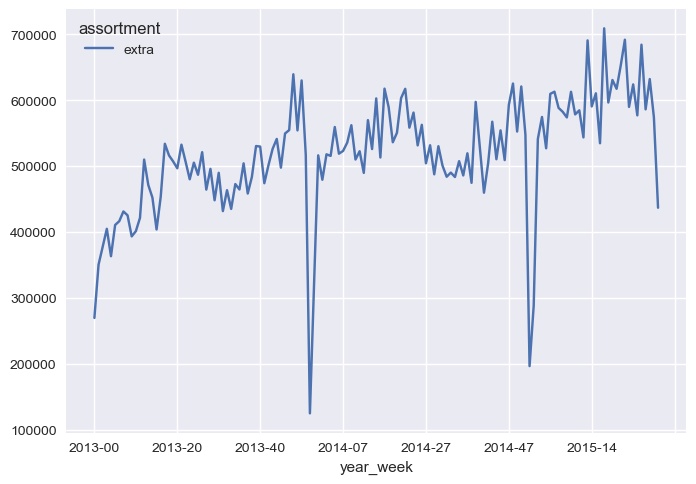

In [42]:

sales_assortment = df4[['sales','assortment']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=sales_assortment)

sales_assortment_time = df4[['sales','assortment','year_week']].groupby(['assortment','year_week']).sum().reset_index()
sales_assortment_time.pivot(index='year_week',columns='assortment',values='sales').plot()

sales_assortment_time_extra = df4.loc[df4['assortment'] == 'extra',['year_week','sales','assortment']].groupby(['assortment','year_week']).sum().reset_index()
sales_assortment_time_extra.pivot(index='year_week',columns='assortment',values='sales').plot()


### 4.2.2 - H2 - Loja com competidores mais próximos deveriam vender menos.
**Falso. Lojas com competidores mais próximos vende MAIS.**


C:\Users\edils\AppData\Local\Temp\ipykernel_19056\911036185.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df4_competition_distance.corr(method='pearson'),annot=True)


<Axes: >

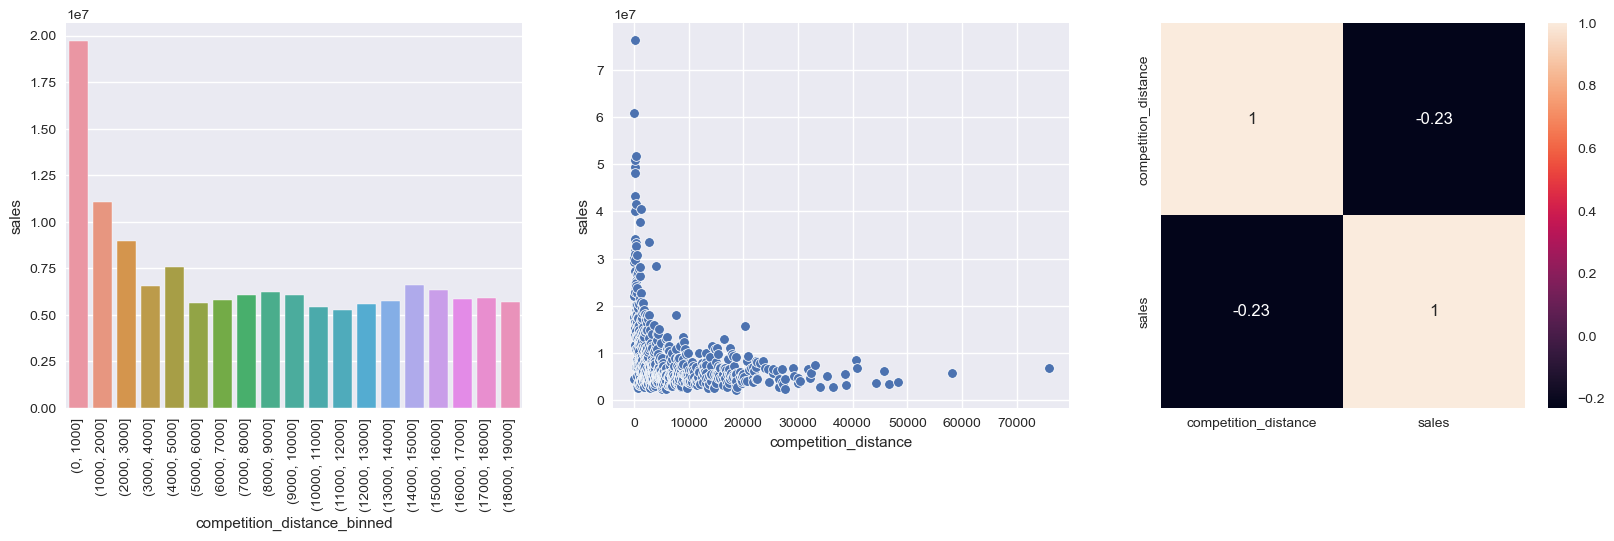

In [43]:
df4_competition_distance = df4.loc[:,['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0,20000,1000))
df4_competition_distance['competition_distance_binned'] = pd.cut(df4_competition_distance['competition_distance'], bins=bins)

fig = plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.barplot(x='competition_distance_binned',y='sales',data=df4_competition_distance, errorbar=None)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
mask = df4_competition_distance.loc[df4_competition_distance['competition_distance'] < 100000,:]
sns.scatterplot(x='competition_distance',y='sales',data=mask )

plt.subplot(1,3,3)
sns.heatmap(df4_competition_distance.corr(method='pearson'),annot=True)



### 4.2.3 - H3 - Lojas com competidores a mais tempo deveriam vender mais.
**Falso. Lojas com competidores mais recentes vende MAIS.**

<Axes: >

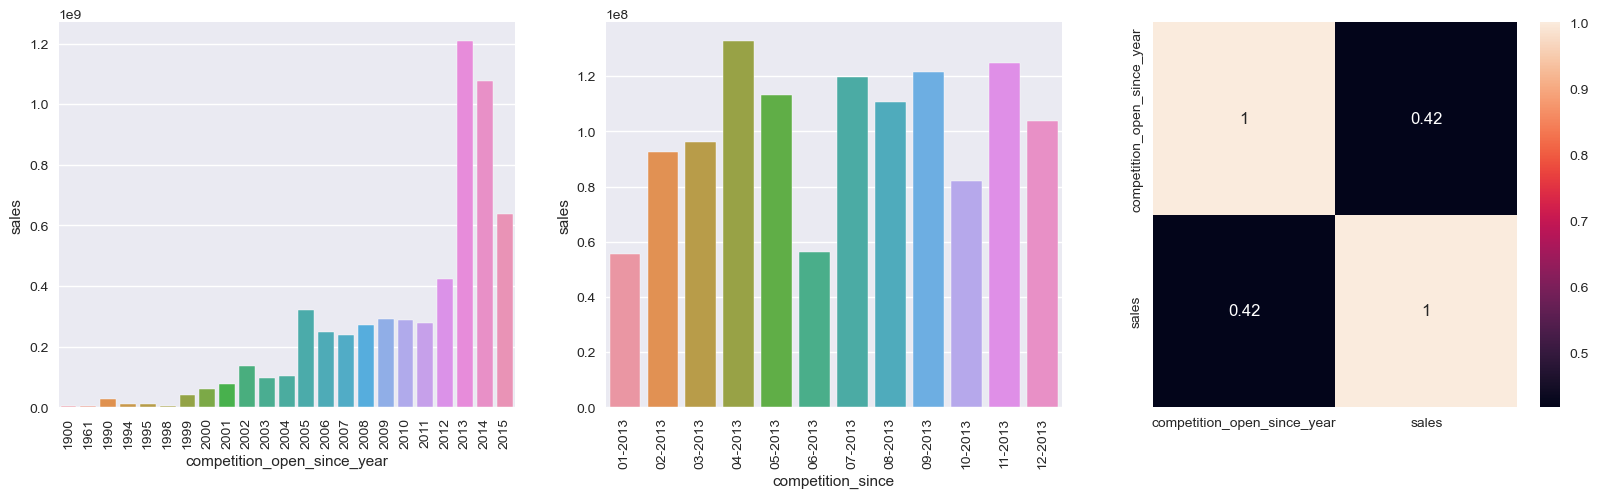

In [44]:
fig = plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
df4_competition_time = df4.loc[:,['competition_open_since_year','sales']].groupby('competition_open_since_year').sum().reset_index()
sns.barplot(x='competition_open_since_year',y='sales',data=df4_competition_time)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
df4_competition_time_2013 = df4.loc[df4['competition_since'].dt.year == 2013,['competition_since','sales']].groupby('competition_since').sum().reset_index()
df4_competition_time_2013['competition_since'] = df4_competition_time_2013['competition_since'].dt.strftime('%m-%Y')
sns.barplot(x='competition_since',y='sales',data=df4_competition_time_2013)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(df4_competition_time.corr(method='pearson'),annot=True)


### 4.2.4 H4 - Lojas com Promoções ativas por mais tempo deveiriam vender mais. Falso. As vendas se mantém relativamente constantes após a promoção.


In [45]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week,competition_time_month
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,2015-07-27,0,84
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,2010-03-22,279,94
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,2011-03-28,226,105
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,2015-07-27,0,71
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,2015-07-27,0,4


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

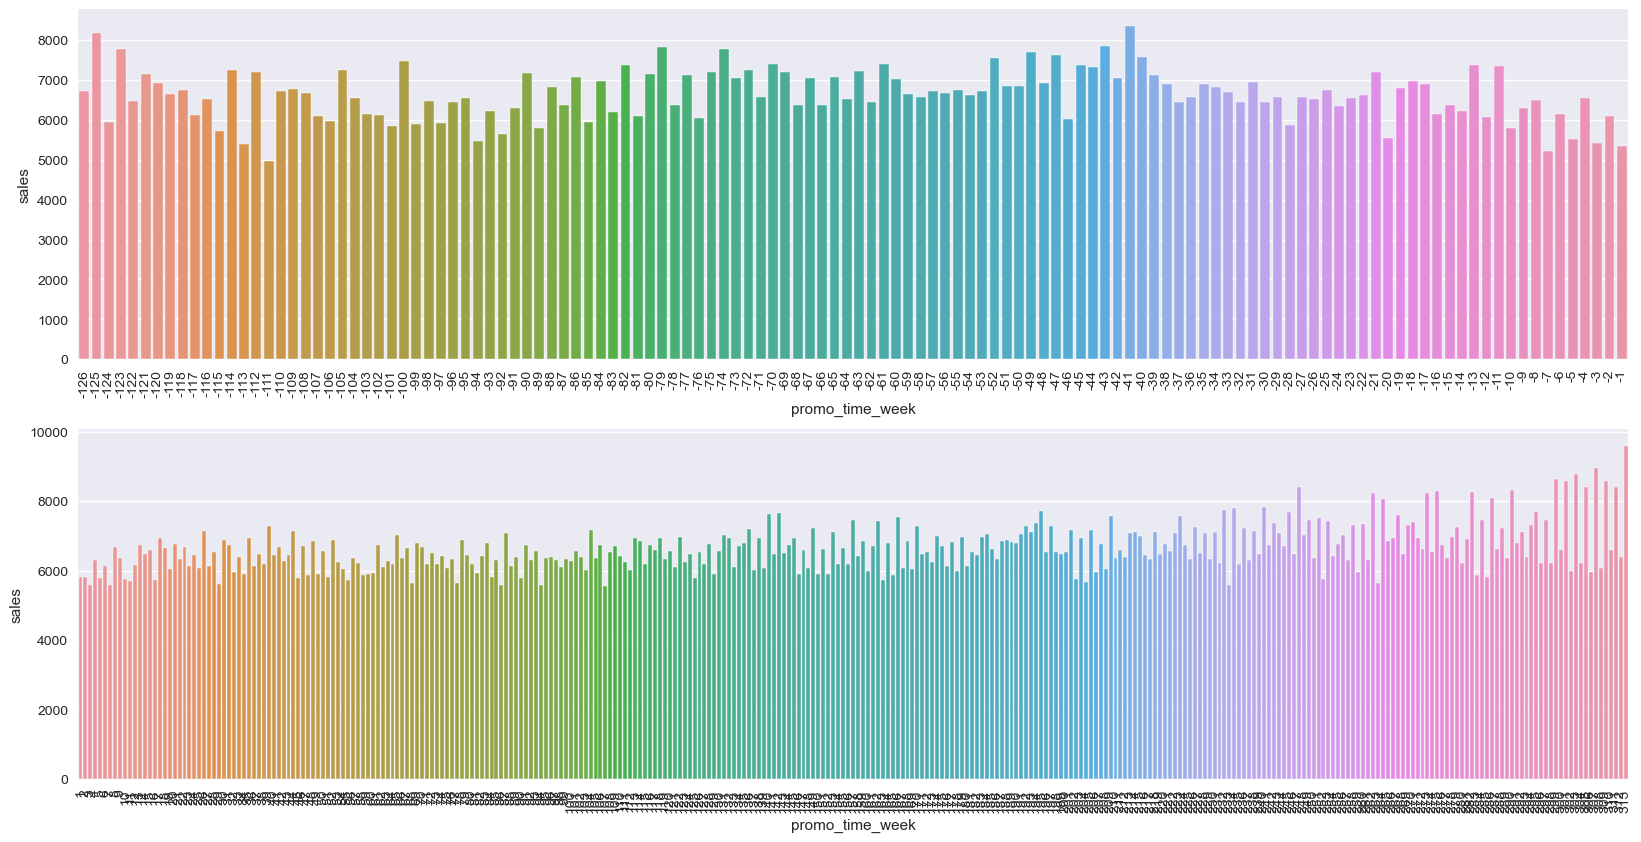

In [46]:
df4_promo_since_regular = df4.loc[df4['promo_time_week'] < 0,:] #regular promo
df4_promo_since_promo2 = df4.loc[df4['promo_time_week']> 0,:]

fig = plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
sns.barplot(x='promo_time_week',y='sales',data=df4_promo_since_regular, errorbar=None)
plt.xticks(rotation=90)

plt.subplot(2,1,2)
sns.barplot(x='promo_time_week',y='sales',data=df4_promo_since_promo2, errorbar=None)
plt.xticks(rotation=90)



### 4.2.5 H7 - Lojas com mais promoções consecutivas deveriam vender mais. Falso. Lojas com promocões consecutivas vendem Menos.

In [47]:
df4.loc[:,['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


<Axes: xlabel='year_week', ylabel='sales'>

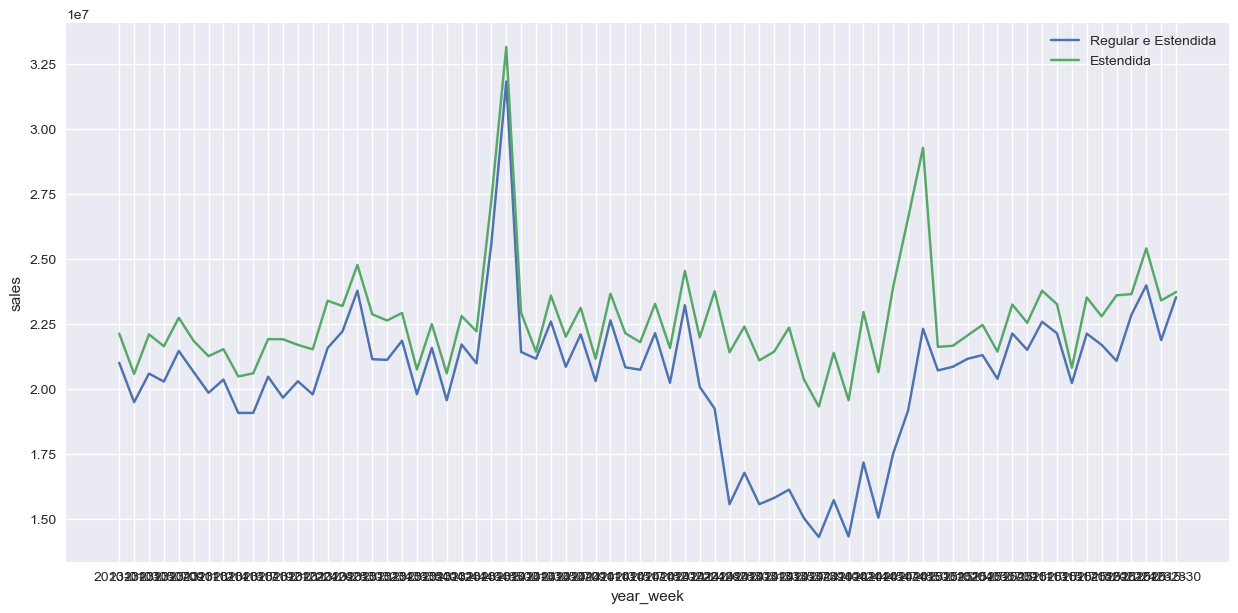

In [48]:
df4_regular_extendida = df4.loc[(df4['promo'] == 1) & (df4['promo2'] == 1),['sales','year_week']].groupby('year_week').sum().reset_index()
df4_apenas_extendida = df4.loc[(df4['promo'] == 1) & (df4['promo2'] == 0),['sales','year_week']].groupby('year_week').sum().reset_index()

plt.figure(figsize=(15,7))

sns.lineplot(x='year_week',y='sales',data=df4_regular_extendida, label='Regular e Estendida')

sns.lineplot(x='year_week',y='sales',data=df4_apenas_extendida, label='Estendida')


### H8. Lojas aberturas durante o Natal Deveriam vender mais. Falso. O Natal é o feriado que menos vende.

<Axes: xlabel='year', ylabel='sales'>

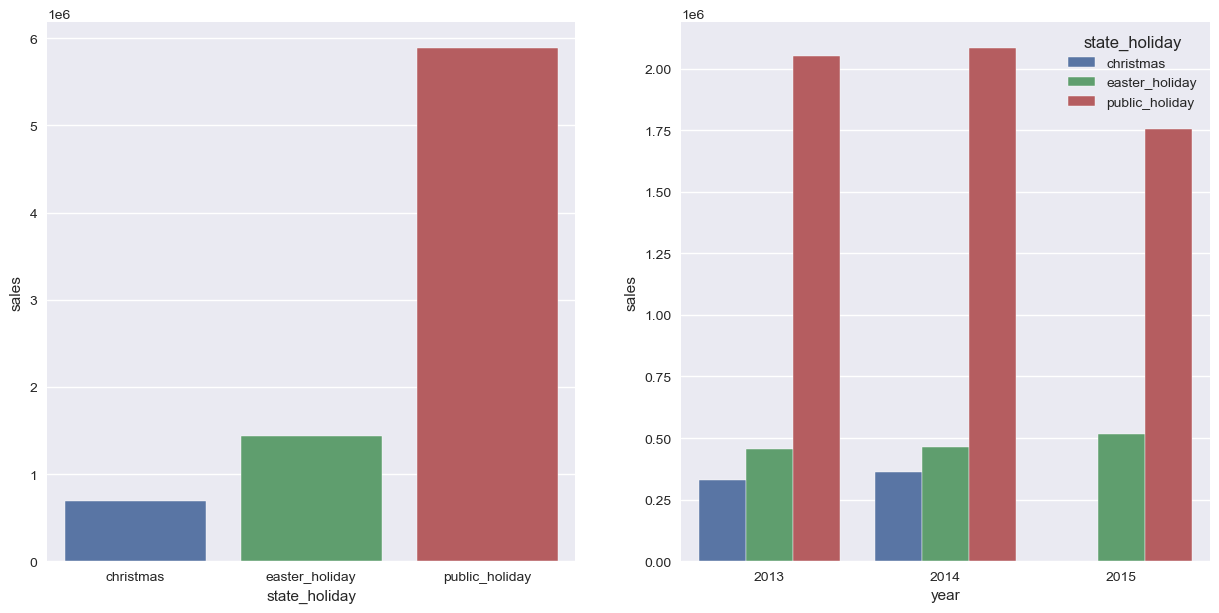

In [49]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
df4_christmas = df4.loc[df4['state_holiday'] != 'regular_day',['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=df4_christmas)

plt.subplot(1,2,2)
df4_christmas = df4.loc[df4['state_holiday'] != 'regular_day',['state_holiday','sales','year']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=df4_christmas, errorbar=None)


### H9. Lojas deveriam vender mais ao longo dos anos. Falso. As vendas caem ao longo dos anos

<Axes: >

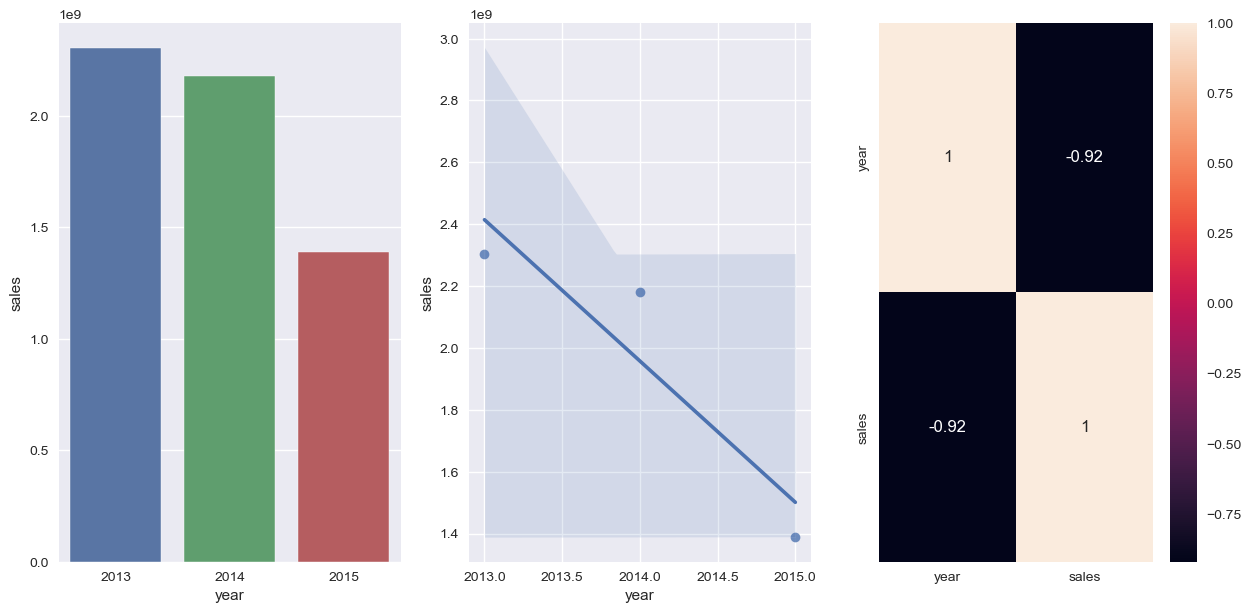

In [50]:
df4_vendas_anos = df4.loc[:,['sales','year']].groupby('year').sum().reset_index()

plt.figure(figsize=(15,7))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=df4_vendas_anos)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=df4_vendas_anos)

plt.subplot(1,3,3)
sns.heatmap(df4_vendas_anos.corr(method='pearson'), annot=True)

### H10. Lojas deveriam vender mais no segundo semestre. As lojas vendem menos no segundo semestre do ano

<Axes: >

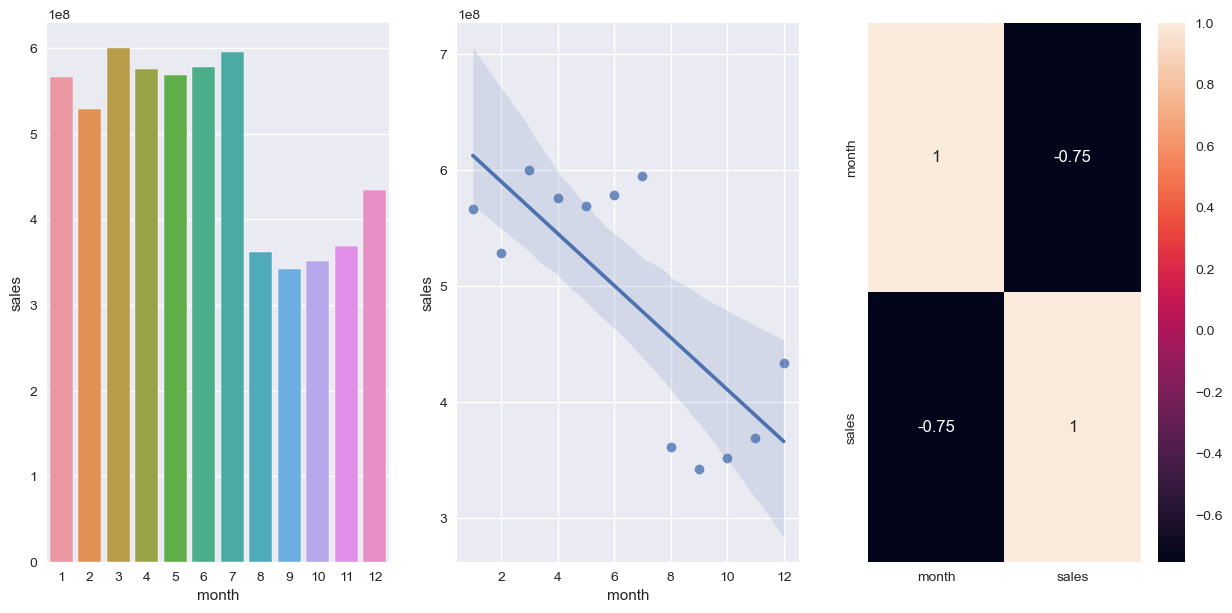

In [51]:
df4_vendas_meses = df4.loc[:,['sales','month']].groupby('month').sum().reset_index()

plt.figure(figsize=(15,7))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=df4_vendas_meses)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=df4_vendas_meses)

plt.subplot(1,3,3)
sns.heatmap(df4_vendas_meses.corr(method='pearson'), annot=True)

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês. Verdade. As lojas tem uma quantidade de vendas maiores após o dia 10.

<Axes: xlabel='before_after', ylabel='sales'>

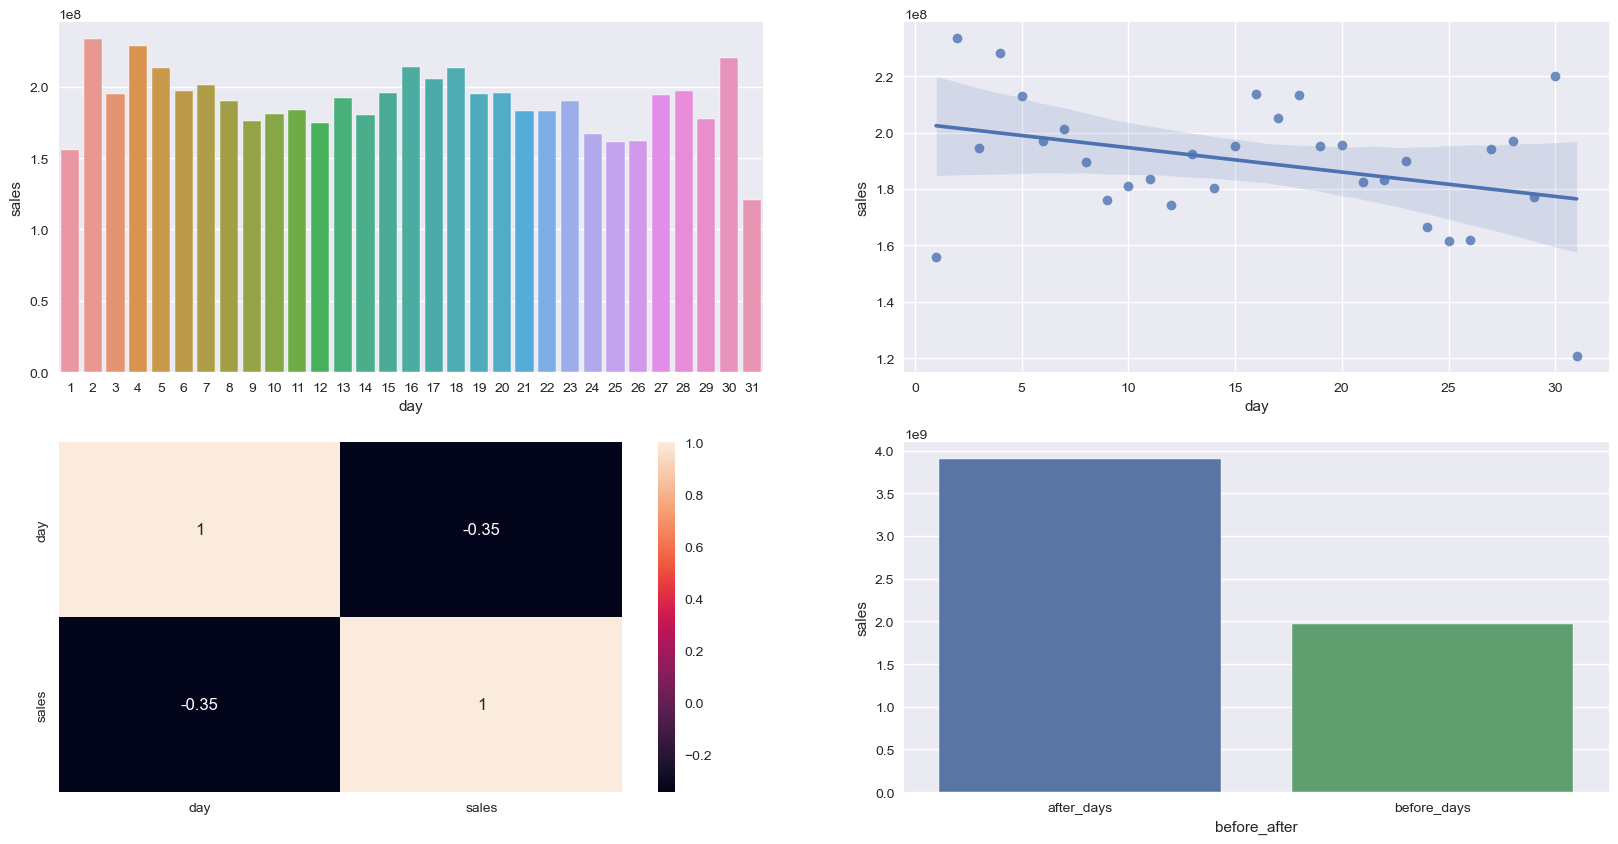

In [52]:
df4_vendas_dias = df4.loc[:,['sales','day']].groupby('day').sum().reset_index()

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=df4_vendas_dias)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=df4_vendas_dias)

plt.subplot(2,2,3)
sns.heatmap(df4_vendas_dias.corr(method='pearson'), annot=True)

plt.subplot(2,2,4)
df4_vendas_dias['before_after'] = df4_vendas_dias['day'].apply(lambda x: 'after_days' if x > 10 else 'before_days')
df4_before_after = df4_vendas_dias.loc[:,['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=df4_before_after, errorbar=None)

### H12. Lojas deveriam vender menos aos finais de semana. VERDADE. Lojas vendem bem menos durante os fins de semana.

<Axes: xlabel='weekend', ylabel='sales'>

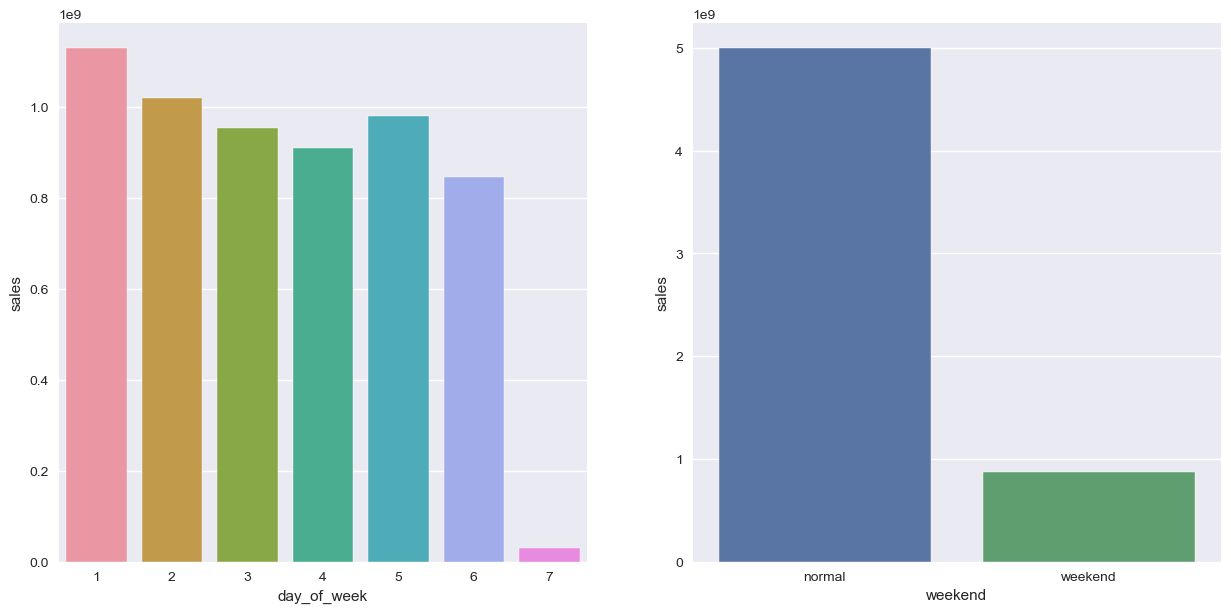

In [53]:
df4_vendas_fds = df4.loc[:,['sales','day_of_week']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
sns.barplot(x='day_of_week', y='sales', data=df4_vendas_fds)


df4_vendas_fds['weekend'] = df4_vendas_fds['day_of_week'].apply(lambda x: 'weekend' if x >=6 else 'normal')
df4_weekend = df4_vendas_fds.loc[:,['weekend','sales']].groupby('weekend').sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x='weekend', y='sales', data=df4_weekend)

### H13. Vendas deveriam ser menor nos feriados escolares. VERDADE. Detalhe para o mês 7 que quase se igualam.

<Axes: xlabel='month', ylabel='sales'>

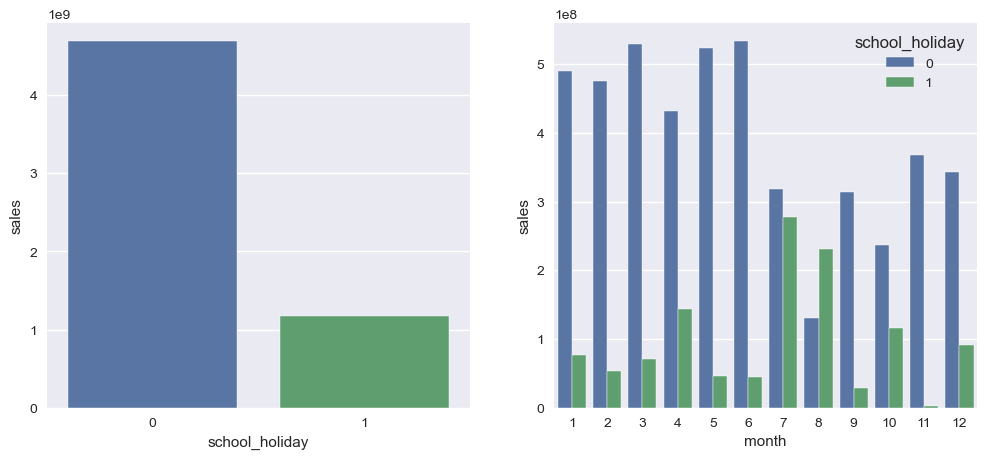

In [54]:
fig = plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
df4_school_holiday = df4.loc[:,['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=df4_school_holiday)

plt.subplot(1,2,2)
df4_school_holiday_month = df4.loc[:,['school_holiday','sales','month']].groupby(['school_holiday','month']).sum().reset_index()
sns.barplot(x='month', y='sales', data=df4_school_holiday_month, hue='school_holiday')

### 4.1.4 Resumo das Hipóteses

In [55]:
from tabulate import tabulate

In [56]:
tab = [['Hipóteses','Conclusão','Relevância'],
       ['H1','Falsa','Baixa'],
       ['H2','Falsa','Media'],
       ['H3','Falsa','Media'],
       ['H4','Falsa','Baixa'],
       ['H5','-','-'],
       ['H7','Falsa','Baixa'],
       ['H8','Falsa','Media'],
       ['H9','Falsa','Alta'],
       ['H10','Falsa','Alta'],
       ['H11','Verdadeira','Alta'],
       ['H12','Verdadeira','Alta'],
       ['H13','Verdadeira','Baixa'],
       ]
print(tabulate(tab, headers='firstrow'))       

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Multivarial Analysis

<Axes: >

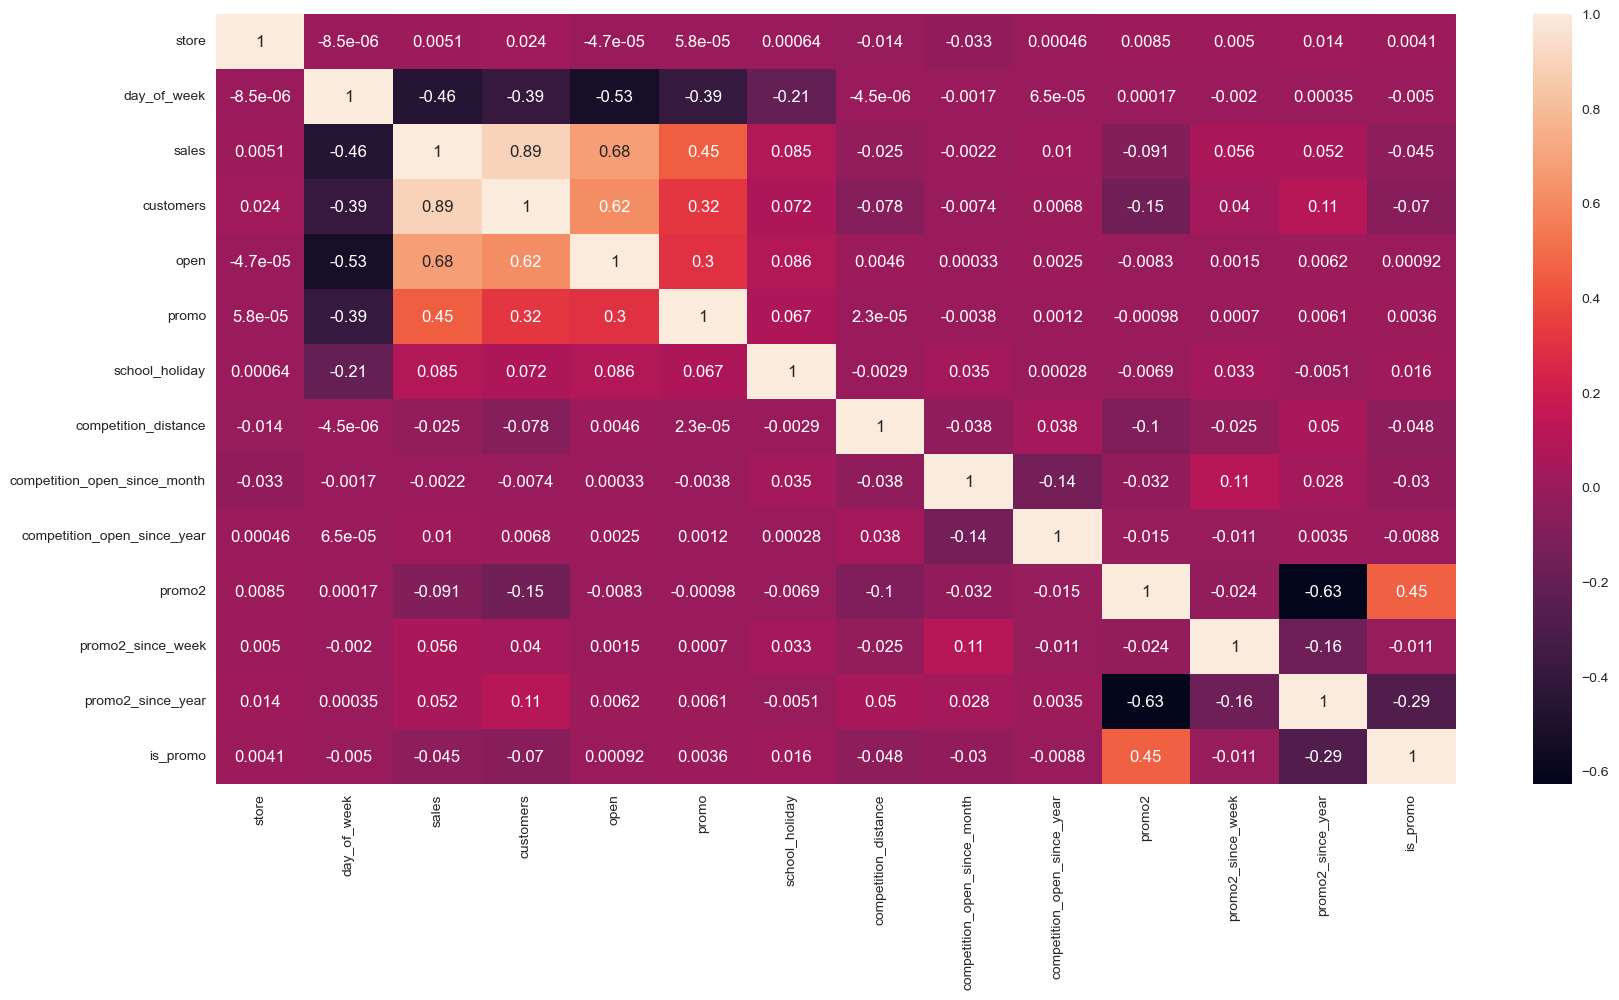

In [57]:
#Correlação entre numericos
plt.figure(figsize=(20,10))
correlacao_num = num_attributes.corr(method='pearson')
sns.heatmap(correlacao_num, annot=True)

In [58]:
#Correlação entre Categoricas
a = df4.select_dtypes(include='object')

<Axes: >

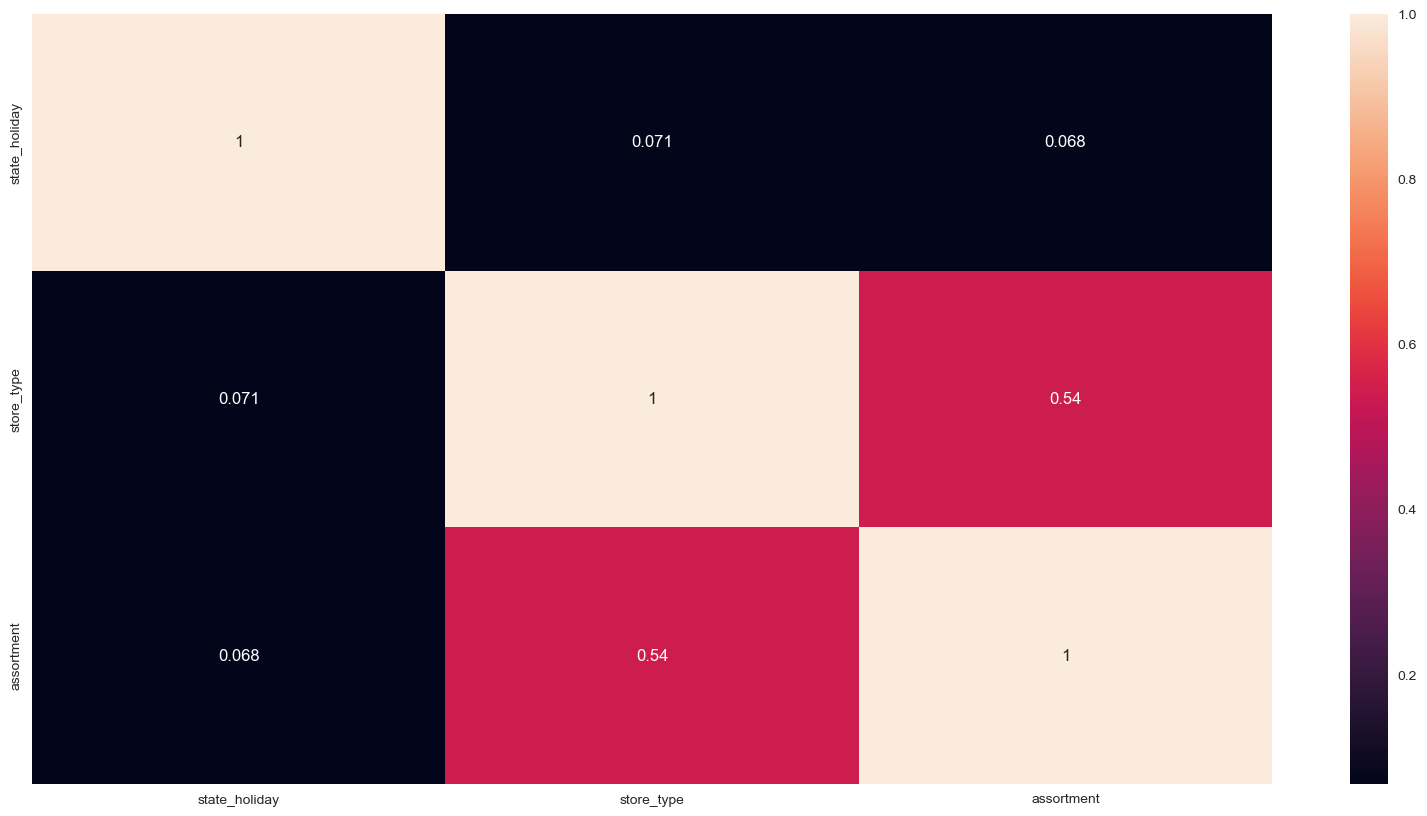

In [59]:
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )
plt.figure(figsize=(20,10))
sns.heatmap( d, annot=True )

# 5.0 DATA PREPARATION


In [60]:
df5 = df4.copy()

## 5.1 Normalization

In [61]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week,competition_time_month
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,2015-07-27,0,84
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,2010-03-22,279,94
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,2011-03-28,226,105
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,2015-07-27,0,71
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,2015-07-27,0,4


## 5.2 Rescalling

In [62]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
#tem que usar o reshape porque o robust scaler pede
df5['competition_distance'] = rs.fit_transform(df5['competition_distance'].values.reshape(-1,1))

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5['competition_time_month'].values.reshape(-1,1))


#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5['promo_time_week'].values.reshape(-1,1))

#year
df5['year'] = mms.fit_transform(df5['year'].values.reshape(-1,1))


## 5.3 Transformation


## 5.3.1 Encoding

In [63]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoder
le = LabelEncoder()

df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment
types_assortment = {'basic': 1,
                    'extra': 2,
                    'extended': 3}
df5['assortment'] = df5['assortment'].map(types_assortment)

## 5.3.2 Response variable transformation

In [64]:
#Transformação logarítmica da RESPOSTA
##jogar a distribuição que estava muito na esquerda para mais para direito e do centro
df5['sales'] = np.log1p(df5['sales'])

C:\Users\edils\AppData\Local\Temp\ipykernel_19056\4056287585.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df5['sales'])


<Axes: xlabel='sales', ylabel='Density'>

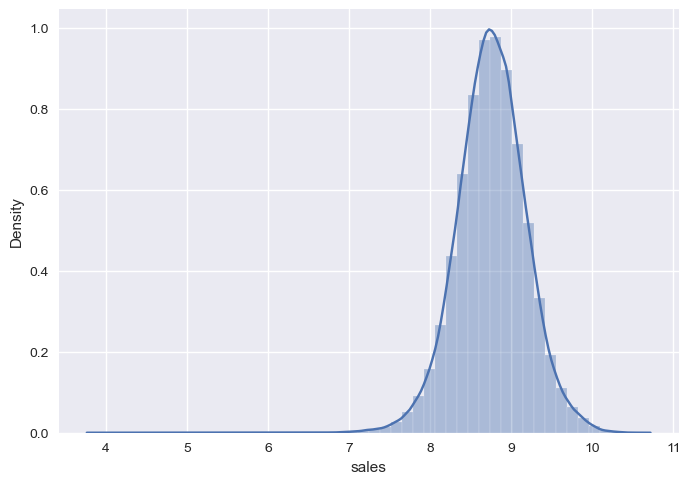

In [65]:
sns.distplot(df5['sales'])

## 5.3.3 Nature Transformation

In [66]:
#day_of_week
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))
df5['day_of_week_sen'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
#day
df5['day_sen'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))
#week_of_year
df5['week_of_year_sen'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
#month
df5['month_sen'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# 6.0 FEATURE SELECTION


In [67]:
df6 = df5.copy()

In [68]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_time_week,competition_time_month,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_cos,day_of_week_sen,day_sen,day_cos,week_of_year_sen,week_of_year_cos,month_sen,month_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,2015-07-27,0.287016,0.918919,0,0,0,1,-0.222521,-0.974928,0.207912,0.978148,-0.568065,-0.822984,-0.5,-0.866025
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,2010-03-22,0.922551,1.054054,0,0,0,1,-0.222521,-0.974928,0.207912,0.978148,-0.568065,-0.822984,-0.5,-0.866025
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,2011-03-28,0.801822,1.202703,0,0,0,1,-0.222521,-0.974928,0.207912,0.978148,-0.568065,-0.822984,-0.5,-0.866025
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,2015-07-27,0.287016,0.743243,0,0,0,1,-0.222521,-0.974928,0.207912,0.978148,-0.568065,-0.822984,-0.5,-0.866025
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,2015-07-27,0.287016,-0.162162,0,0,0,1,-0.222521,-0.974928,0.207912,0.978148,-0.568065,-0.822984,-0.5,-0.866025


## 6.1 Split dataframe into training and test 

In [69]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)

In [70]:
df_ultima_data = df6.loc[:,['store','date']].groupby('store').max().reset_index()
df_ultima_data.iloc[0,1] - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [71]:
#training dataset
x_train = df6.loc[df6['date'] < '2015-06-19']
y_train = x_train['sales']

#test_dataset
x_test = df6.loc[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print(x_train['date'].min())
print(x_train['date'].max())
print(x_test['date'].min())
print(x_test['date'].max())

2013-01-01 00:00:00
2015-06-18 00:00:00
2015-06-19 00:00:00
2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [72]:
x_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,promo_time_week,competition_time_month,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_cos,day_of_week_sen,day_sen,day_cos,week_of_year_sen,week_of_year_cos,month_sen,month_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,0,25,2015,0,1.0,0.287016,0.891892,0,0,0,1,-0.900969,-0.433884,-0.587785,-0.809017,0.120537,-0.992709,1.224647e-16,-1.0
47946,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,0.908884,1.027027,0,0,0,1,-0.900969,-0.433884,-0.587785,-0.809017,0.120537,-0.992709,1.224647e-16,-1.0
47947,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,0.788155,1.189189,0,0,0,1,-0.900969,-0.433884,-0.587785,-0.809017,0.120537,-0.992709,1.224647e-16,-1.0
47948,4,2015-06-18,9.091669,1,0,2,3,-0.275806,9,2009,0,25,2015,0,1.0,0.287016,0.729730,0,0,0,1,-0.900969,-0.433884,-0.587785,-0.809017,0.120537,-0.992709,1.224647e-16,-1.0
47949,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,0,25,2015,0,1.0,0.287016,-0.189189,0,0,0,1,-0.900969,-0.433884,-0.587785,-0.809017,0.120537,-0.992709,1.224647e-16,-1.0


In [73]:
#training and test dataset for Boruta
#dropou o 'date' porque já era uma variável que seria dropada antes mas manteve para filtrar a data e o sales é a resposta
x_train_n = x_train.drop(['date','sales'], axis=1).values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)



In [74]:
#define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n) #verbose=2 ele vai printando conforme vai fazendo
                                                                                                #random_state = 42 ele vai partir sempre do mesmo inicio

In [75]:
#cols_boruta = boruta.support_.tolist()

#best features
#x_train_fs = x_train.drop(['sales','date'], axis=1)
#cols_selected_boruta = x_train_fs.loc[:,cols_boruta].columns.to_list()

#not seleected boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

### 6.3 Boruta Selection

In [93]:
cols_selected_boruta = [
         'store',
         'promo',
         'store_type',
         'assortment',
         'competition_distance',
         'competition_open_since_month',
         'competition_open_since_year',
         'promo2',
         'promo2_since_week',
         'promo2_since_year',
         'promo_time_week',
         'competition_time_month',
         'day_of_week_cos',
         'day_of_week_sen',
         'day_sen',
         'day_cos',
         'week_of_year_cos',
         'week_of_year_sen',
         'month_sen',
         'month_cos']

#columns to add
feat_to_add = ['date','sales']

#final_features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [94]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_time_week',
 'competition_time_month',
 'day_of_week_cos',
 'day_of_week_sen',
 'day_sen',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sen',
 'month_sen',
 'month_cos']

# 7.0 MACHINE LEARNING MODELS

In [210]:
df7 = df6.copy()
x_train = x_train.loc[:,cols_selected_boruta]
x_test = x_test.loc[:,cols_selected_boruta]

## 7.1 Average Model

In [211]:
# aux1 = x_test.copy()
# aux1['sales'] = y_test.copy()

# #prediction
# media_aux1 = aux1.loc[:,['sales','store']].groupby('store').mean().reset_index().rename(columns={'sales':'prediction'})
# aux1 = pd.merge(aux1, media_aux1, how='left', on='store')
# yhat_baseline = aux1['prediction']

# #performance
# baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
# baseline_result



,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [80]:
# #model
# lr = LinearRegression()

# #training
# lr.fit(x_train, y_train)

# #prediction
# yhat_lr = lr.predict(x_test)

# #performance
# lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
# lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.3 Linear Regression Regularized Model - Lasso

In [81]:
# #model
# #o alpha multiplica todos os pesos para que normalize eles e nenhum tendencie o modelo
# lrr = Lasso(alpha=0.01)

# #training
# lrr.fit(x_train, y_train)

# #prediction
# yhat_lrr = lrr.predict(x_test)

# #performance
# lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
# lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451741


## 7.4 Random Forest Regressor

In [212]:
# #model
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# #training
# rf.fit(x_train, y_train)

# #prediction
# yhat_rf = rf.predict(x_test)

# #performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
# rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.854054,0.100115,1012.68713


## 7.5 XGBoost Regressor

In [213]:
# #model
# model_xgb = xgb.XGBRegressor()
# #training
# model_xgb.fit(x_train, y_train)

# #prediction
# yhat_xgb = model_xgb.predict(x_test)

# #performance
# xgb_result = ml_error('XGB Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
# xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGB Regressor,868.958205,0.130309,1238.550843


## 7.6 Compare Model's Performance

In [218]:
#pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result]).sort_values(by='RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.854054,0.100115,1012.687130
0,XGB Regressor,868.958205,0.130309,1238.550843
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451741
0,Linear Regressor,1980.039151,0.283893,2840.000319


## 7.7 Cross Validation

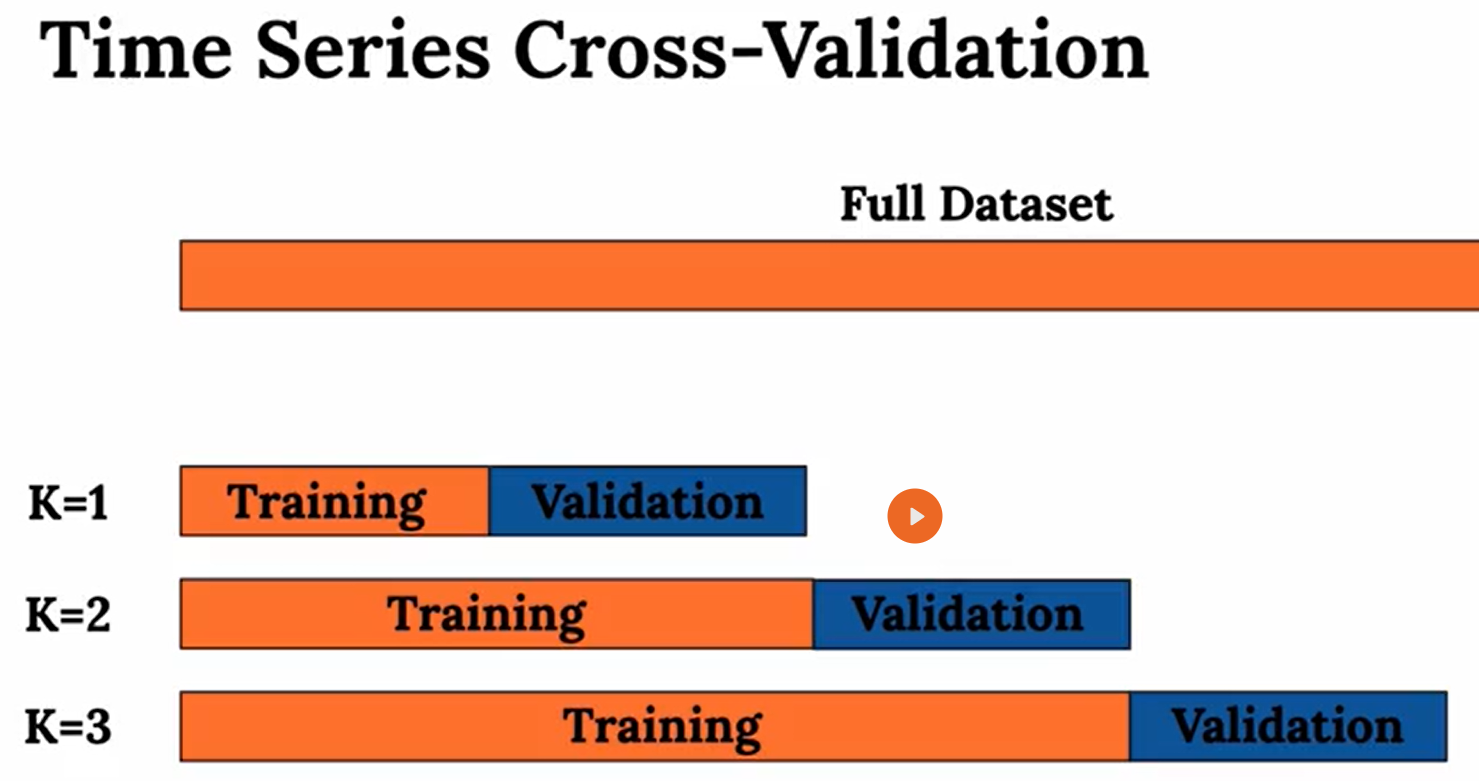

In [109]:
Image(filename='C:\\Users\\edils\\repos\\ds_em_producao\\Captura de tela 2023-05-01 103114.png')

In [214]:
#jogar date e sales denovo na variável x_train
#training dataset
x_train = df6.loc[df6['date'] < '2015-06-19']
y_train = x_train['sales']

#test_dataset
x_test = df6.loc[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

In [136]:
x_training = x_train.loc[:,cols_selected_boruta_full]


### 7.7.1 Linear Regression Model - Cross Validation 

In [195]:
#lr_result_cv = cross_validation(x_training, 5, 'Linear Regressoion', LinearRegression(), verbose=True)


K-Fold Number: 5

K-Fold Number: 4

K-Fold Number: 3

K-Fold Number: 2

K-Fold Number: 1


In [196]:
#lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regressoion,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


In [197]:
#lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regressor,1980.039151,0.283893,2840.000319


### 7.7.2 Linear Regression Model Regularized(LASSO) - Cross Validation 

In [201]:
#lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', Lasso(alpha=0.01), verbose=True)


K-Fold Number: 5

K-Fold Number: 4

K-Fold Number: 3

K-Fold Number: 2

K-Fold Number: 1


In [202]:
#lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


In [200]:
#lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451741


### 7.7.3 Random Forest Regressor - Cross Validation 

In [203]:
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

In [204]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)


K-Fold Number: 5

K-Fold Number: 4

K-Fold Number: 3

K-Fold Number: 2

K-Fold Number: 1


In [216]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.83 +/- 217.3,0.12 +/- 0.02,1255.04 +/- 316.89


### 7.7.4 XGBoost Regressor - Cross Validation 

In [205]:
model_xgb = xgb.XGBRegressor()

In [206]:
#xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)


K-Fold Number: 5

K-Fold Number: 4

K-Fold Number: 3

K-Fold Number: 2

K-Fold Number: 1


In [217]:
#xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1060.51 +/- 178.41,0.15 +/- 0.02,1512.59 +/- 241.37


In [219]:
#results = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result]).sort_values(by='RMSE')

In [221]:
#results_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv]).sort_values(by='RMSE CV')

In [222]:
#print(results)
#print(results_cv)

                  Model Name          MAE      MAPE         RMSE
0    Random Forest Regressor   680.854054  0.100115  1012.687130
0              XGB Regressor   868.958205  0.130309  1238.550843
0              Average Model  1354.800353  0.206400  1835.135542
0  Linear Regression - Lasso  1891.704881  0.289106  2744.451741
0           Linear Regressor  1980.039151  0.283893  2840.000319
                  Model Name              MAE CV        MAPE CV             RMSE CV
0    Random Forest Regressor    836.83 +/- 217.3  0.12 +/- 0.02  1255.04 +/- 316.89
0          XGBoost Regressor  1060.51 +/- 178.41  0.15 +/- 0.02  1512.59 +/- 241.37
0         Linear Regressoion  2081.73 +/- 295.63   0.3 +/- 0.02  2952.52 +/- 468.37
0  Linear Regression - Lasso   2116.38 +/- 341.5  0.29 +/- 0.01  3057.75 +/- 504.26


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [250]:
warnings.filterwarnings('ignore')

param = {
        'n_estimators': [150, 180, 220, 270, 350],
        'eta': [0.01, 0.03, 0.07],
        'max_depth': [3, 6, 9],
        'subsample': [0.1, 0.4, 0.8],
        'colsample_bytree': [0.2, 0.4, 0.7],
        'min_child_weight': [4, 9, 14]}

max_eval = 5



In [251]:
# final_result = pd.DataFrame()

# for i in range(max_eval):
#     #choose values for parameters randomly
#     hp_aleat = {
#         'n_estimators': random.choice(param['n_estimators']),
#         'eta': random.choice(param['eta']),
#         'max_depth': random.choice(param['max_depth']),
#         'subsample': random.choice(param['subsample']),
#         'colsample_bytree': random.choice(param['colsample_bytree']),
#         'min_child_weight': random.choice(param['min_child_weight'])} 
#     print(hp_aleat)

#     #model
#     model_xgb = xgb.XGBRegressor(
#                                 n_estimators=hp_aleat['n_estimators'],
#                                 eta=hp_aleat['eta'],
#                                 max_depth=hp_aleat['max_depth'],
#                                 subsample=hp_aleat['subsample'],
#                                 colsample_bytree=hp_aleat['colsample_bytree'],
#                                 min_child_weight=hp_aleat['min_child_weight'])

#     #performance
#     result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=True)
#     final_result = pd.concat([final_result, result])
# final_result    

{'n_estimators': 180, 'eta': 0.07, 'max_depth': 6, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 14}

K-Fold Number: 2

K-Fold Number: 1
{'n_estimators': 270, 'eta': 0.07, 'max_depth': 6, 'subsample': 0.1, 'colsample_bytree': 0.2, 'min_child_weight': 4}

K-Fold Number: 2

K-Fold Number: 1
{'n_estimators': 270, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.4, 'colsample_bytree': 0.4, 'min_child_weight': 14}

K-Fold Number: 2

K-Fold Number: 1
{'n_estimators': 350, 'eta': 0.07, 'max_depth': 6, 'subsample': 0.1, 'colsample_bytree': 0.4, 'min_child_weight': 14}

K-Fold Number: 2

K-Fold Number: 1
{'n_estimators': 350, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.2, 'min_child_weight': 4}

K-Fold Number: 2

K-Fold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1396.1 +/- 36.05,0.19 +/- 0.0,2039.59 +/- 74.24
0,XGBoost Regressor,1475.65 +/- 48.51,0.2 +/- 0.0,2154.05 +/- 85.31
0,XGBoost Regressor,1286.48 +/- 37.64,0.17 +/- 0.0,1892.76 +/- 83.49
0,XGBoost Regressor,1215.85 +/- 38.57,0.16 +/- 0.0,1770.92 +/- 85.16
0,XGBoost Regressor,2563.54 +/- 109.78,0.3 +/- 0.01,3562.85 +/- 163.63


## 8.2 Final Model

In [246]:
x_train = x_train.loc[:,cols_selected_boruta]
x_test = x_test.loc[:,cols_selected_boruta]

In [259]:
param_tuned = {
        'n_estimators': 3500,
        'eta': 0.07,
        'max_depth': 6,
        'subsample': 0.1,
        'colsample_bytree': 0.4,
        'min_child_weight':14}

In [260]:
# #model
# model_xgb_tunned = xgb.XGBRegressor(
#                                 n_estimators=param_tuned['n_estimators'],
#                                 eta=param_tuned['eta'],
#                                 max_depth=param_tuned['max_depth'],
#                                 subsample=param_tuned['subsample'],
#                                 colsample_bytree=param_tuned['colsample_bytree'],
#                                 min_child_weight=param_tuned['min_child_weight'])
# #training
# model_xgb_tunned.fit(x_train, y_train)

# #prediction
# yhat_xgb_tunned = model_xgb_tunned.predict(x_test)



# #performance
# xgb_result_tunned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tunned))
# xgb_result_tunned    

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,695.985642,0.102112,1007.379751


Meu range da variável resposta varia de 569 reais até 41550 reais, o meu erro é em média de 695 reais(MAE)
minha média de valores é 6995, o que significa que esse MAE é em torno de 10%, que é o que diz o MAPE
o RMSE considera mais os outliers, pq eleva ao quadrado. RMSE é mais usado para melhorar o modelo 
e o MAE e MAPE para reportar para time de negócios.
o MPE é bom para ver se o modelo está super/sub estimando, porque ele considera o erro negativa e positivo,
porém não pode ser usado para medir performance do modelo

In [272]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tunned))

-0.0009128131520023834

MPE negativo significa que na maioria das predições, o erro tende a ser MAIOR que o valor REAL, então o modelo está SUPERestimando

In [261]:
import pickle

In [269]:
pickle.dump(model_xgb_tunned, open('C:\\Users\\edils\\repos\\ds_em_producao\\Data-Science-Em-Producao\\model_rossman.pkl', 'wb'))

# 9.0 ERROR TRADUCTION

In [275]:
#test_dataset
x_test = df6.loc[df6['date'] >= '2015-06-19']

df9 = x_test.loc[:,cols_selected_boruta_full]

#rescale
df9['sales']

## 9.1 Business Performance

## 9.2 Total Performance

## 9.3 Machine Learning Performance